In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
import time
import pickle
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\Appzone-MLG\Anaconda3\envs\chest_xray_env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### loading the dataset

In [38]:
def load_data(size=1000):
    train_df = pd.read_csv("CheXpert-v1.0-small/train_data.csv", nrows=size)
    valid_df = pd.read_csv("CheXpert-v1.0-small/valid.csv")

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            zoom_range=0.2,
            horizontal_flip=False)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="path",
            y_col=['no_finding',
                   'enlarged_cardiomediastinum',
                   'cardiomegaly',
                   'lung_opacity',
                   'lung_lesion',
                   'edema',
                   'consolidation',
                   'pneumonia',
                   'atelectasis',
                   'pneumothorax',
                   'pleural_effusion',
                   'pleural_other',
                   'fracture',
                   'support_devices'
                   ],
            color_mode="grayscale",
            target_size=(128, 128),
            batch_size=32,
            shuffle=False,
            class_mode="raw"
    )

    validation_generator = test_datagen.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col="Path",
            y_col=['No Finding',
                   'Enlarged Cardiomediastinum',
                   'Cardiomegaly',
                   'Lung Opacity',
                   'Lung Lesion',
                   'Edema',
                   'Consolidation',
                   'Pneumonia',
                   'Atelectasis',
                   'Pneumothorax',
                   'Pleural Effusion',
                   'Pleural Other',
                   'Fracture',
                   'Support Devices'
                  ],
            color_mode="grayscale",
            target_size=(128, 128),
            batch_size=128,
            class_mode="raw",
            shuffle=False
    )
    
    return train_generator, validation_generator

In [39]:
# load data with 2000 rows
train_generator, validation_generator = load_data(size=6400)

Found 6400 validated image filenames.
Found 234 validated image filenames.


### Creating the ResNet Archiecture Identity block

In [4]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

### Implementing the ResNet50 model

In [6]:
def ResNet50(input_shape=(64, 64, 1), classes=14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
print("My Custom ResNet50 model:")
plot_model(ResNet50(), to_file='custom-resnet-50.png', show_shapes=True, show_layer_names=True)

My Custom ResNet50 model:









In [8]:
resnet_50 = ResNet50(input_shape = (128, 128, 1), classes = 14)

resnet_50.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# filepath contains location for storing keras models with the lowwest loss function after every 10 epoch
filepath="models/weights-resnet50-size-2000-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.hdf5"
tensor_log_name = f"resnet50-2000-dataset-{int(time.time())}"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min',
                             period=10
                            )
#                           save_freq=5

tensorboard = TensorBoard(log_dir = f'logs/{tensor_log_name}', histogram_freq=0, batch_size=32)

In [10]:
start_time = time.time()

resnet_50_history = resnet_50.fit_generator(
        train_generator,    
        steps_per_epoch=200,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2,
        callbacks=[checkpoint, tensorboard]
)

print("--- %s seconds ---" % (time.time() - start_time))



Epoch 1/50
200/200 [==============================] - 48s 241ms/step - loss: 0.6590 - acc: 0.8331 - val_loss: 0.7527 - val_acc: 0.7869
Epoch 2/50
200/200 [==============================] - 41s 204ms/step - loss: 0.5573 - acc: 0.8345 - val_loss: 0.7169 - val_acc: 0.7869
Epoch 3/50
200/200 [==============================] - 41s 206ms/step - loss: 0.5313 - acc: 0.8345 - val_loss: 0.6034 - val_acc: 0.7882
Epoch 4/50
200/200 [==============================] - 41s 203ms/step - loss: 0.5336 - acc: 0.8340 - val_loss: 0.6591 - val_acc: 0.7863
Epoch 5/50
200/200 [==============================] - 41s 203ms/step - loss: 0.5655 - acc: 0.8333 - val_loss: 0.6297 - val_acc: 0.7888
Epoch 6/50
200/200 [==============================] - 41s 203ms/step - loss: 0.5479 - acc: 0.8345 - val_loss: 0.6410 - val_acc: 0.7875
Epoch 7/50
200/200 [==============================] - 41s 203ms/step - loss: 0.5108 - acc: 0.8348 - val_loss: 0.5947 - val_acc: 0.7882
Epoch 8/50
200/200 [==============================] -

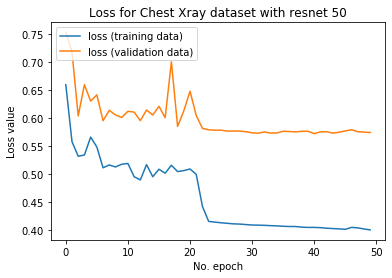

In [26]:
import matplotlib.pyplot as plt

# Plot history: MAE
plt.plot(resnet_50_history.history['loss'], label='loss (training data)')
plt.plot(resnet_50_history.history['val_loss'], label='loss (validation data)')
plt.title('Loss for Chest Xray dataset with resnet 50')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

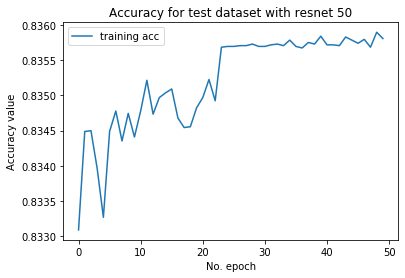

In [27]:
# Plot history: MAE
plt.plot(resnet_50_history.history['acc'], label='training acc')
plt.title('Accuracy for test dataset with resnet 50')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

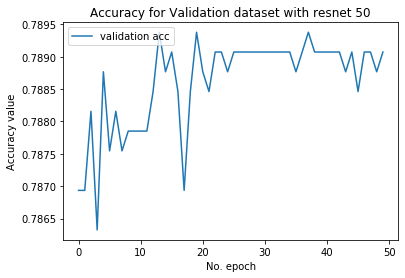

In [28]:
# Plot history: MAE
plt.plot(resnet_50_history.history['val_acc'], label='validation acc')
plt.title('Accuracy for Validation dataset with resnet 50')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
# save complete model
resnet_50.save('models/complete-model/custom_resNet_50.h5')

In [19]:
# save model weight hdf5
resnet_50.save_weights('models/model-weight/custom_resNet_50.hdf5')

### Evaluation resnet 50 model

In [7]:
loaded_resnet_50 = load_model('models/complete-model/custom_resNet_50.h5')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
valid_df = pd.read_csv("CheXpert-v1.0-small/valid.csv")
y_true = valid_df.iloc[:,5:].values

In [33]:
y_true.shape

(234, 14)

In [34]:
y_pred_50 = loaded_resnet_50.predict_generator(validation_generator, steps=2)

In [74]:
y_pred_50_round = np.where(y_pred_50 > 0.1, 1, 0)
y_pred_50_round_0_15 = np.where(y_pred_50 > 0.15, 1, 0)
y_pred_50_round_0_2 = np.where(y_pred_50 > 0.2, 1, 0)

In [50]:
label = ['no_finding',
         'enlarged_cardiomediastinum',
         'cardiomegaly',
         'lung_opacity',
         'lung_lesion',
         'edema','consolidation',
         'pneumonia',
         'atelectasis',
         'pneumothorax',
         'pleural_effusion',
         'pleural_other',
         'fracture',
         'support_devices'
        ]

In [75]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true, y_pred_50_round_0_15)

array([[[170,  26],
        [ 31,   7]],

       [[125,   0],
        [109,   0]],

       [[166,   0],
        [ 68,   0]],

       [[ 12,  96],
        [  9, 117]],

       [[233,   0],
        [  1,   0]],

       [[174,  15],
        [ 37,   8]],

       [[201,   0],
        [ 33,   0]],

       [[226,   0],
        [  8,   0]],

       [[152,   2],
        [ 79,   1]],

       [[216,  10],
        [  8,   0]],

       [[ 79,  88],
        [ 37,  30]],

       [[233,   0],
        [  1,   0]],

       [[234,   0],
        [  0,   0]],

       [[ 20, 107],
        [ 14,  93]]], dtype=int64)

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_50_round, target_names=label))

                            precision    recall  f1-score   support

                no_finding       0.21      0.29      0.24        38
enlarged_cardiomediastinum       0.00      0.00      0.00       109
              cardiomegaly       0.44      0.06      0.10        68
              lung_opacity       0.54      0.98      0.70       126
               lung_lesion       0.00      0.00      0.00         1
                     edema       0.22      0.38      0.28        45
             consolidation       0.00      0.00      0.00        33
                 pneumonia       0.00      0.00      0.00         8
               atelectasis       0.34      0.20      0.25        80
              pneumothorax       0.07      0.38      0.12         8
          pleural_effusion       0.29      0.85      0.43        67
             pleural_other       0.00      0.00      0.00         1
                  fracture       0.00      0.00      0.00         0
           support_devices       0.46      0.93

C:\Users\Appzone-MLG\Anaconda3\envs\chest_xray_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Appzone-MLG\Anaconda3\envs\chest_xray_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Appzone-MLG\Anaconda3\envs\chest_xray_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

In [79]:
print(classification_report(y_true, y_pred_50_round_0_15, target_names=label))

                            precision    recall  f1-score   support

                no_finding       0.21      0.18      0.20        38
enlarged_cardiomediastinum       0.00      0.00      0.00       109
              cardiomegaly       0.00      0.00      0.00        68
              lung_opacity       0.55      0.93      0.69       126
               lung_lesion       0.00      0.00      0.00         1
                     edema       0.35      0.18      0.24        45
             consolidation       0.00      0.00      0.00        33
                 pneumonia       0.00      0.00      0.00         8
               atelectasis       0.33      0.01      0.02        80
              pneumothorax       0.00      0.00      0.00         8
          pleural_effusion       0.25      0.45      0.32        67
             pleural_other       0.00      0.00      0.00         1
                  fracture       0.00      0.00      0.00         0
           support_devices       0.47      0.87

In [84]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true[1], y_pred_50_round[1])
# rocs = []
# for i in range(234):
#     rocs.append(roc_auc_score(y_true[i], y_pred_50_round[i]))
# avg_roc = sum(rocs)/234
# print(avg_roc)

0.9230769230769231

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true[0], y_pred_50_round_0_15[0])

0.7857142857142857

In [80]:
accs = []

for i in range(234):
    accs.append(accuracy_score(y_true[i], y_pred_50_round[i]))
    
avg_acc = sum(accs)/234

print(avg_acc)

0.7249694749694747


In [29]:
# valid_df = pd.read_csv("CheXpert-v1.0-small/valid.csv")
# y = 
# import pickle

# example_dict = {1:"6",2:"2",3:"f"}

# pickle_out = open("dict.pickle","wb")
# pickle.dump(example_dict, pickle_out)
# pickle_out.close()

In [33]:
# resnet_50_history
pickle_out = open("pickle-history/resnet_50_history.pickle", "wb")
pickle.dump(resnet_50_history, pickle_out)
pickle_out.close()

In [34]:
# loading and testing the pickle
pickle_in = open("pickle-history/resnet_50_history.pickle","rb")
loaded_resent_50_history = pickle.load(pickle_in)

In [36]:
# # Plot history: MAE
# plt.plot(loaded_resent_50_history.history['val_acc'], label='validation acc')
# plt.title('Accuracy for Validation dataset with resnet 50')
# plt.ylabel('Accuracy value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.show()

### Implementing the ResNet101 model

In [37]:
def ResNet101(input_shape=(64, 64, 1), classes=14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='g')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='h')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='i')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='j')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='k')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='l')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='m')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='n')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='o')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='p')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='q')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='r')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='s')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='t')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='u')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='v')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='w')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='x')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='y')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='z')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet101')

    return model

In [38]:
print("My Custom ResNet101 model:")
plot_model(ResNet101(), to_file='custom-resnet-101.png', show_shapes=True, show_layer_names=True)

My Custom ResNet101 model:


In [45]:
resnet_101 = ResNet101(input_shape = (128, 128, 1), classes = 14)

resnet_101.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

In [48]:
# filepath contains location for storing keras models with the lowwest loss function after every 10 epoch
filepath="models/weights-resnet101-size-6400-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.hdf5"
tensor_log_name = f"resnet101-6400-dataset-{int(time.time())}"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min',
                             period=10
                            )
#                           save_freq=5

tensorboard = TensorBoard(log_dir = f'logs/{tensor_log_name}', histogram_freq=0, batch_size=32)

In [49]:
start_time = time.time()

resnet_101_history = resnet_101.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2,
        callbacks=[checkpoint, tensorboard]
)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
200/200 [==============================] - 79s 394ms/step - loss: 0.5106 - acc: 0.8346 - val_loss: 0.5848 - val_acc: 0.7912
Epoch 2/50
200/200 [==============================] - 78s 388ms/step - loss: 0.5774 - acc: 0.8335 - val_loss: 1.7518 - val_acc: 0.7988
Epoch 3/50
200/200 [==============================] - 78s 388ms/step - loss: 0.5675 - acc: 0.8334 - val_loss: 0.6287 - val_acc: 0.7772
Epoch 4/50
200/200 [==============================] - 77s 387ms/step - loss: 0.5124 - acc: 0.8350 - val_loss: 0.6610 - val_acc: 0.8001
Epoch 5/50
200/200 [==============================] - 77s 387ms/step - loss: 0.4884 - acc: 0.8351 - val_loss: 0.5976 - val_acc: 0.7839
Epoch 6/50
200/200 [==============================] - 77s 387ms/step - loss: 0.4838 - acc: 0.8354 - val_loss: 0.5919 - val_acc: 0.7906
Epoch 7/50
200/200 [==============================] - 77s 387ms/step - loss: 0.4926 - acc: 0.8349 - val_loss: 0.6196 - val_acc: 0.7967
Epoch 8/50
200/200 [==============================] - 7

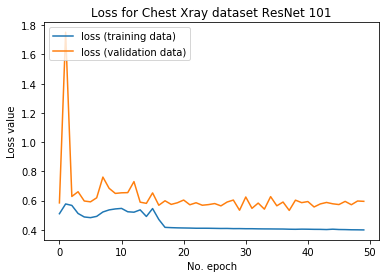

In [50]:
# Plot history: Loss
plt.plot(resnet_101_history.history['loss'], label='loss (training data)')
plt.plot(resnet_101_history.history['val_loss'], label='loss (validation data)')
plt.title('Loss for Chest Xray dataset ResNet 101')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

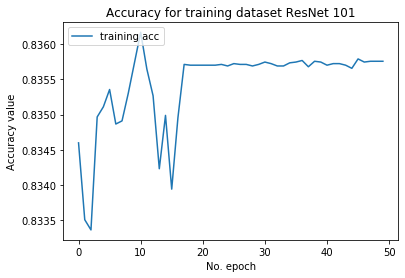

In [51]:
# Plot history: MAE
plt.plot(resnet_101_history.history['acc'], label='training acc')
plt.title('Accuracy for training dataset ResNet 101')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

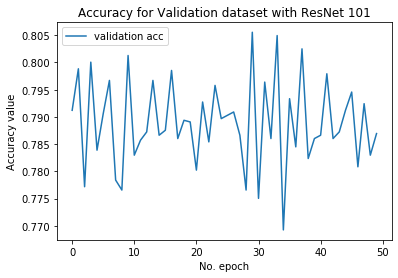

In [52]:
# Plot history: MAE
plt.plot(resnet_101_history.history['val_acc'], label='validation acc')
plt.title('Accuracy for Validation dataset with ResNet 101')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [53]:
# saving history pickle resnet 101 in memory
pickle_out = open("pickle-history/resnet_101_history.pickle", "wb")
pickle.dump(resnet_50_history, pickle_out)
pickle_out.close()

In [ ]:
# loading models weights
loaded_resnet_50.load_weights()

In [ ]:
Evaluat

### Implementing the ensemble ResNet model

In [85]:
models = [resnet_50, resnet_101]

In [86]:
from keras.models import Model, Input
from keras.layers import Average
from keras.engine import training
from typing import Tuple, List

In [97]:
def ensemble(models: List [training.Model]) -> training.Model:
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model(Input(shape=(128, 128, 1)), y, name='ensemble_resnet')
    return model

In [85]:
# ensemble_model = ensemble(models)

# ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_6:0", shape=(?, 128, 128, 1), dtype=float32) at layer "input_6". The following previous layers were accessed without issue: []

In [87]:
# resnet_50.outputs[0]
# resnet_50.outputs[0][21]
# ensemble_model.save('models/my_ensemble_resNet.h5')